## Boxplots by Topology (aggregated over system size)

One combined figure with **5 stacked subplots** (throughput, latency, energy, CPU utilization, failure rate). In each subplot, the **x-axis** shows all 6 topologies and the **y-axis** is the metric. **Violin plots** show the distribution shape (density) for spread-out data; inner box shows median and IQR. Data aggregated over all `system_size` (5, 10, 20).

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [36]:
cwd = Path('.').resolve()
candidates = [
    cwd.parent / '5_results_data' / 'run_table.csv',
    cwd / '5_results_data' / 'run_table.csv',
]
RUN_TABLE_PATH = next((p for p in candidates if p.exists()), candidates[0])
FIGURES_DIR = cwd / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
print("Data:", RUN_TABLE_PATH, "| Exists:", RUN_TABLE_PATH.exists())

Data: /home/irena/Documents/Research Project/topology-scale-mubench-replication/5_results_data/run_table.csv | Exists: True


In [37]:
df = pd.read_csv(RUN_TABLE_PATH)
df = df[df['__done'] == 'DONE'].copy()

TOPOLOGY_ORDER = [
    'sequential_fanout', 'parallel_fanout', 'chain_with_branching',
    'hierarchical_tree', 'probabilistic_tree', 'complex_mesh',
]
TOPOLOGY_LABELS = {
    'sequential_fanout': 'Seq FO', 'parallel_fanout': 'Par FO',
    'chain_with_branching': 'Chain', 'hierarchical_tree': 'Hierarchical',
    'probabilistic_tree': 'Probabilistic', 'complex_mesh': 'Mesh',
}

METRIC_BLOCKS = [
    ('throughput_rps', 'Throughput (RPS)'),
    ('avg_latency_ms', 'Avg Response Time (ms)'),
    ('energy', 'CPU Package Energy (J)'),
    ('cpu_usage_avg', 'CPU Utilization (%)'),
    ('failure_rate', 'Failure rate (%)'),
]

df = df[df['topology'].isin(TOPOLOGY_ORDER)]
df['topology'] = pd.Categorical(df['topology'], categories=TOPOLOGY_ORDER, ordered=True)

_scale_pct = (
    ('cpu_usage_avg' in df.columns and df['cpu_usage_avg'].max() <= 1.5)
    or ('failure_rate' in df.columns and df['failure_rate'].max() <= 1.5)
)
if _scale_pct:
    df = df.copy()
    if 'cpu_usage_avg' in df.columns and df['cpu_usage_avg'].max() <= 1.5:
        df['cpu_usage_avg'] = df['cpu_usage_avg'] * 100
    if 'failure_rate' in df.columns and df['failure_rate'].max() <= 1.5:
        df['failure_rate'] = df['failure_rate'] * 100

print("Rows:", len(df), "| Topologies:", df['topology'].nunique(), "| Sizes:", sorted(df['system_size'].unique().tolist()))

Rows: 180 | Topologies: 6 | Sizes: [5, 10, 20]


In [38]:
def remove_outliers(series):
    """IQR-based outlier removal (like reference)."""
    if series is None or len(series) == 0:
        return series
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series >= lower) & (series <= upper)]

/tmp/ipykernel_75607/4160808351.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='topology_label', y='value', order=x_order, palette=palette,
/tmp/ipykernel_75607/4160808351.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='topology_label', y='value', order=x_order, palette=palette,
/tmp/ipykernel_75607/4160808351.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='topology_label', y='value', order=x_order, palette=palette,
/tmp/ipykernel_75607/4160808351.py:29: FutureWarning

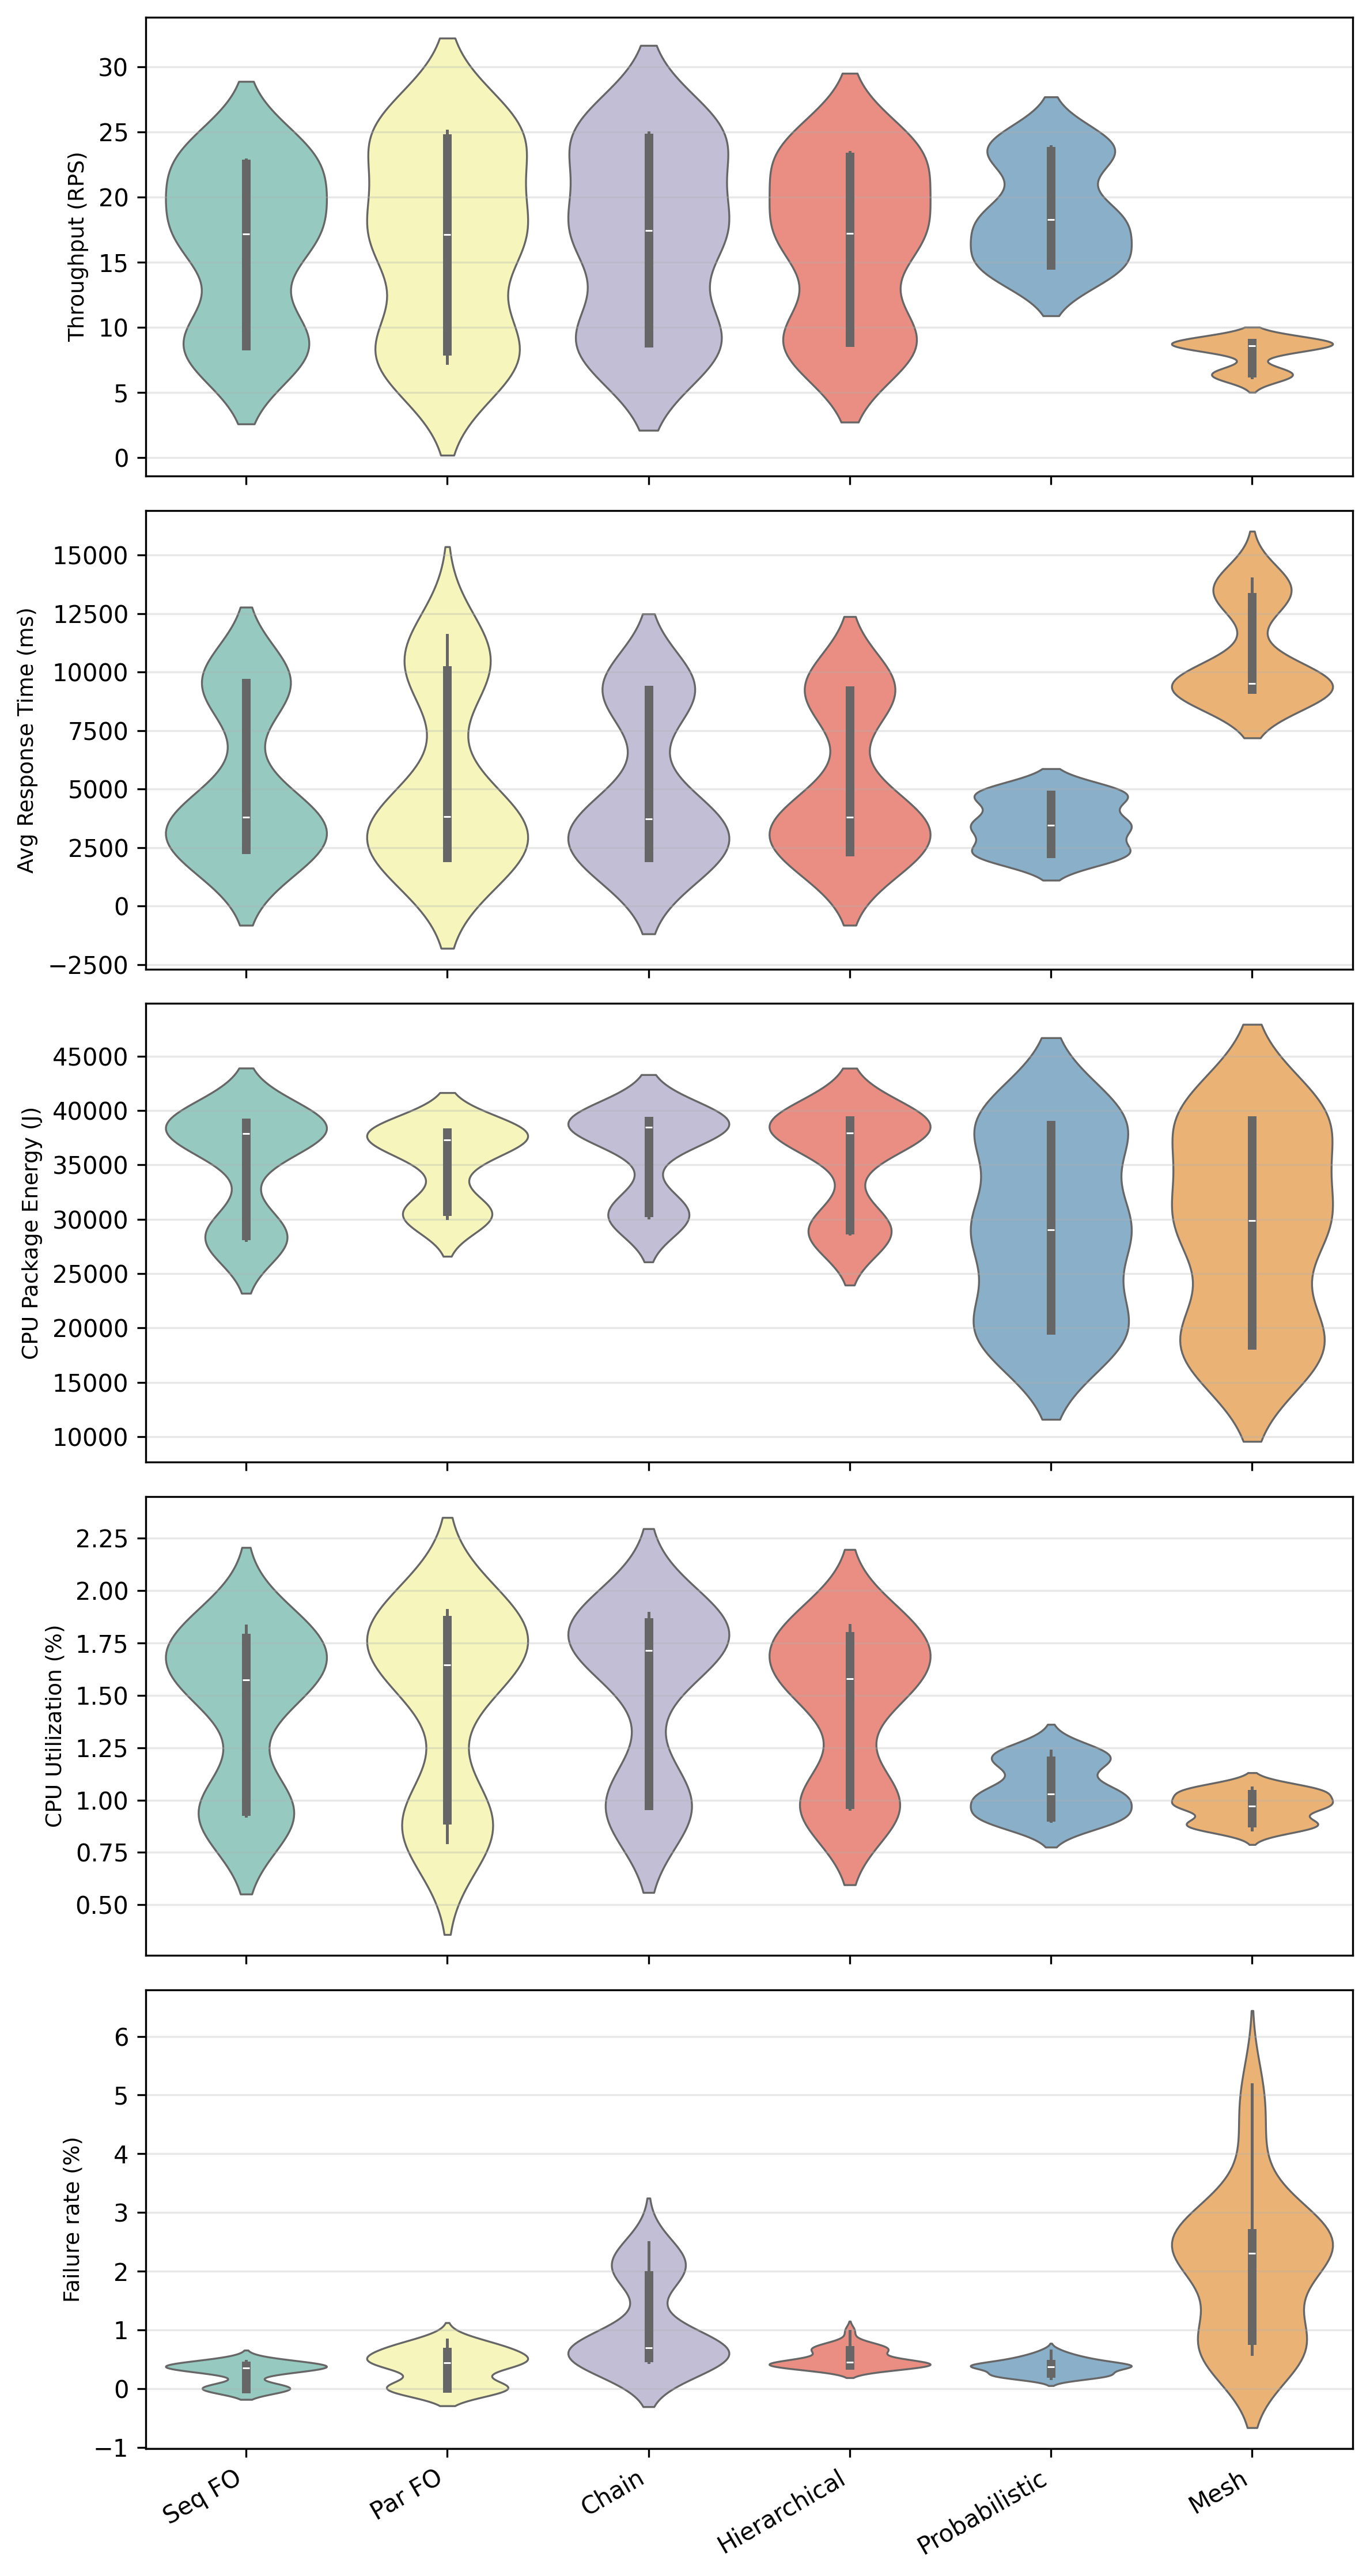

In [39]:
# One combined figure: 5 stacked subplots — violin plots (distribution shape + inner box).
TOPOLOGY_COLORS = [
    '#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462',
]
topology_colors = {t: TOPOLOGY_COLORS[i] for i, t in enumerate(TOPOLOGY_ORDER)}
x_order = [TOPOLOGY_LABELS[t] for t in TOPOLOGY_ORDER]
palette = {TOPOLOGY_LABELS[t]: topology_colors[t] for t in TOPOLOGY_ORDER}

metrics_to_plot = [(col, title) for col, title in METRIC_BLOCKS if col in df.columns]
if not metrics_to_plot:
    raise ValueError("No metric columns found in df")
n_metrics = len(metrics_to_plot)

fig, axs = plt.subplots(n_metrics, 1, figsize=(8, 3 * n_metrics), dpi=300, sharex=True)
if n_metrics == 1:
    axs = [axs]

for ax, (metric_col, metric_title) in zip(axs, metrics_to_plot):
    rows = []
    for topo in TOPOLOGY_ORDER:
        series = df[df['topology'] == topo][metric_col].dropna()
        series_clean = remove_outliers(series)
        for v in series_clean:
            rows.append({'topology_label': TOPOLOGY_LABELS[topo], 'value': v})
    plot_df = pd.DataFrame(rows)
    if plot_df.empty:
        ax.set_ylabel(metric_title, fontsize=9)
        continue
    sns.violinplot(data=plot_df, x='topology_label', y='value', order=x_order, palette=palette,
                   ax=ax, inner='box', linewidth=0.8)
    ax.set_ylabel(metric_title, fontsize=9)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_xlabel('')

axs[-1].set_xticklabels(axs[-1].get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()
base = 'boxplot_all_metrics_by_topology_aggregated'
plt.savefig(FIGURES_DIR / f'{base}.pdf', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / f'{base}.png', dpi=300, bbox_inches='tight')
# LaTeX snippet to include the figure (use from same dir as PDF or set \\graphicspath)
tex_path = FIGURES_DIR / f'{base}.tex'
tex_path.write_text(
    '\\begin{figure}[htbp]\n'
    '  \\centering\n'
    f'  \\includegraphics[width=\\textwidth]{{{base}.pdf}}\n'
    '  \\caption{Metrics by topology (aggregated over system size). '
    'Violin plots show distribution shape; inner box = median and IQR.}\n'
    f'  \\label{{fig:boxplot-all-metrics}}\n'
    '\\end{figure}\n'
)
plt.show()
plt.close()